### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
df = pd.read_csv(r'data/Social_Network_Ads.csv')

In [3]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
df.drop('User ID', axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           400 non-null    object
 1   Age              400 non-null    int64 
 2   EstimatedSalary  400 non-null    int64 
 3   Purchased        400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


In [6]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


### Train Test Split

In [7]:
X = df.drop('Purchased', axis=1)
y = df['Purchased']

In [8]:
X.shape, y.shape

((400, 3), (400,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### See if the Numerical data follow Normal Distribution

#### Using pandas skew()

In [10]:
df.skew(numeric_only=True)

Age                0.231337
EstimatedSalary    0.495024
Purchased          0.596903
dtype: float64

* Columns - Age is almost following normal distribution but EstimatedSalary is Right Skewed. Hence we need to apply FunctionTransformer. (Purchased is Output feature)

#### Using QQ Plot

In [11]:
def plot_QQ(col):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(X_train[col])
    plt.title(f'PDF of {col}')

    plt.subplot(122)
    stats.probplot(X_train[col], dist='norm', plot=plt)
    plt.title(f'QQ Plot of {col}');

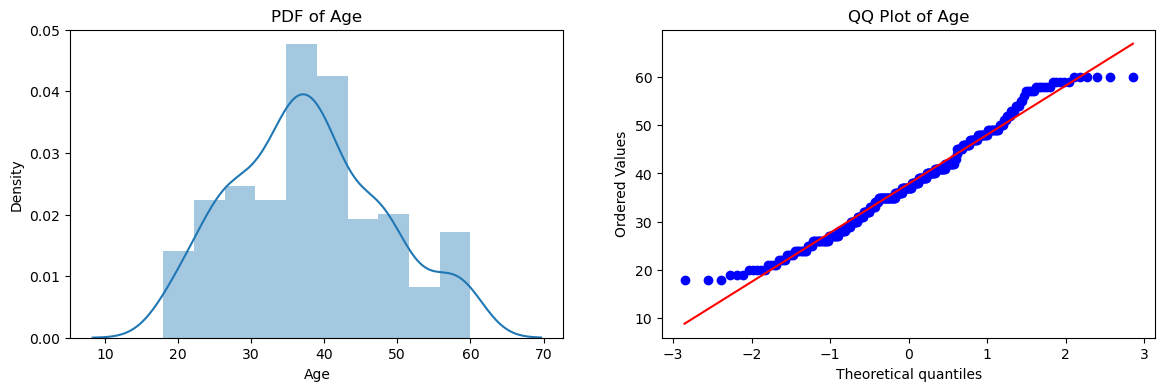

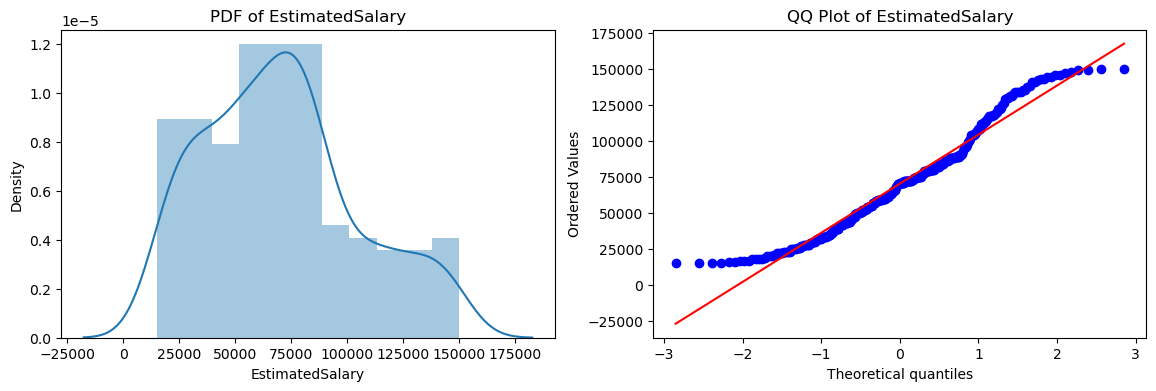

In [12]:
for col in X_train.columns:
    if col == 'Gender':
        continue
    plot_QQ(col)

* Age is almost normally distrubuted but EstimatedSalary is a bit Right Skewed.

### Transformations

In [13]:
X_train.columns

Index(['Gender', 'Age', 'EstimatedSalary'], dtype='object')

* Gender - Nominal Data - OneHotEncoder
* Age - Numerical Data (No missing values) - StandardScaler
* EstimatedSalary - Numerical Data (No missing values) - StandardScaler and Log Transform (using FunctionTransformer)

In [14]:
salary_transformer = Pipeline(steps=[
    ('LogTransform', FunctionTransformer(np.log1p, validate=True)),
    ('Scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('OneHotEncode_Gender', OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), ['Gender']),
        ('Scaler_Age', StandardScaler(), ['Age']),
        ('Scaler_LogTransform_Salary', salary_transformer, ['EstimatedSalary'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True,
    verbose=True
)

### Pipeline using Logistic Regression

In [15]:
pipe = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('Classifier', LogisticRegression())
    ]
)

In [16]:
pipe.fit(X_train, y_train)

[ColumnTransformer]  (1 of 3) Processing OneHotEncode_Gender, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing Scaler_Age, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing Scaler_LogTransform_Salary, total=   0.0s


Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncode_Gender',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                sparse_output=False),
                                                  ['Gender']),
                                                 ('Scaler_Age',
                                                  StandardScaler(), ['Age']),
                                                 ('Scaler_LogTransform_Salary',
                                                  Pipeline(steps=[('LogTransform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['EstimatedSalary'])],
                                   verbose=True)),
                ('Classifier', LogisticRegression())])

### Prediction and Accuracy Score

In [17]:
y_pred = pipe.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.875


### Cross Validation

In [18]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
print("Mean accuracy:", scores.mean())

[ColumnTransformer]  (1 of 3) Processing OneHotEncode_Gender, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing Scaler_Age, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing Scaler_LogTransform_Salary, total=   0.0s
[ColumnTransformer]  (1 of 3) Processing OneHotEncode_Gender, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing Scaler_Age, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing Scaler_LogTransform_Salary, total=   0.0s
[ColumnTransformer]  (1 of 3) Processing OneHotEncode_Gender, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing Scaler_Age, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing Scaler_LogTransform_Salary, total=   0.0s
[ColumnTransformer]  (1 of 3) Processing OneHotEncode_Gender, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing Scaler_Age, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing Scaler_LogTransform_Salary, total=   0.0s
[ColumnTransformer]  (1 of 3) Processing OneHotEncode_Gender, total=   0.0s
[Col